### Bundle & Cross-Selling Recommendation System
### Data Mining Project

# Setup

In [1]:
!pip install nltk plotly seaborn wordcloud scikit-learn gensim mlxtend --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 50)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...


# Data Loading
**Explanation:**  
We load the Amazon products dataset and categories from CSV files. The products dataset contains product information including ASIN, title, price, ratings, and category mappings. The categories file provides category names for each category_id.

In [2]:
# Define data paths
DATA_DIR = "../data"

# Load products data
products_df = pd.read_csv(f"{DATA_DIR}/amazon_products_cleaned.csv")
print(f"Loaded {len(products_df)} products")
print(f"Columns: {products_df.columns.tolist()}")

# Load categories data
categories_df = pd.read_csv(f"{DATA_DIR}/amazon_categories.csv")
print(f"\nLoaded {len(categories_df)} categories")

# Merge products with category names
df = products_df.merge(categories_df, left_on='category_id', right_on='id', how='left')
df = df.drop(columns=['id'])
print(f"\nMerged dataset shape: {df.shape}")
display(df.head())

Loaded 100000 products
Columns: ['asin', 'title', 'imgUrl', 'productURL', 'stars', 'reviews', 'price', 'listPrice', 'category_id', 'isBestSeller', 'boughtInLastMonth']

Loaded 248 categories

Merged dataset shape: (100000, 12)


,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,category_name
0,B07BM9CTPF,"Christian Religious Rubber Bracelet with Card, 2 1/4 Inch",https://m.media-amazon.com/images/I/61AGW4S9YzL._AC_UL320_.jpg,https://www.amazon.com/dp/B07BM9CTPF,4.3,0,14.99,0.00,88,False,0,Boys' Jewelry
1,B07M8GSBRY,"2 Pcs Mickey Ears, Minnie Costume Ears Headband for Children Mom Baby Boys Girls Women Party (RE...",https://m.media-amazon.com/images/I/71EJyf6JpEL._AC_UL320_.jpg,https://www.amazon.com/dp/B07M8GSBRY,4.5,0,8.79,12.99,120,False,100,Women's Accessories
2,B000TZQXXO,35 Light 13.5' Green Wire Red Chili Pepper String,https://m.media-amazon.com/images/I/613hslJHG1L._AC_UL320_.jpg,https://www.amazon.com/dp/B000TZQXXO,4.6,0,15.99,0.00,168,False,0,Seasonal Décor
3,B07SHDN9PX,"DeYeShiKi Motorcycle Mirrors ATV Mirrors, 360 Degrees Ball-Type Adjustment, 7/8"" Handlebar with ...",https://m.media-amazon.com/images/I/61YUQzpAeVL._AC_UL320_.jpg,https://www.amazon.com/dp/B07SHDN9PX,4.4,0,14.85,0.00,28,False,100,Motorcycle & Powersports
4,B09HQQC8CT,Cash Only Sign - 8 x 12 Aluminum - No Credit Card Sign - We Accept Only Cash Sign - Cash Only Si...,https://m.media-amazon.com/images/I/61eEZhQysaL._AC_UL320_.jpg,https://www.amazon.com/dp/B09HQQC8CT,4.1,0,8.49,8.99,161,False,50,Retail Store Fixtures & Equipment


# Data Cleaning
**Explanation:**  
- Missing values are filled or removed to ensure data quality.
- Prices are handled correctly (convert to numeric).
- Product titles are cleaned to prepare for text analysis.
- We create additional features for analysis.

In [3]:
def clean_text(text):
    """Clean and normalize text for analysis"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Clean the dataset
df['cleaned_title'] = df['title'].apply(clean_text)

# Convert types
df['stars'] = pd.to_numeric(df['stars'], errors='coerce')
df['reviews'] = pd.to_numeric(df['reviews'], errors='coerce').fillna(0).astype(int)
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['listPrice'] = pd.to_numeric(df['listPrice'], errors='coerce')
df['boughtInLastMonth'] = pd.to_numeric(df['boughtInLastMonth'], errors='coerce').fillna(0).astype(int)

# Handle missing values
df['stars'] = df['stars'].fillna(0)
df['price'] = df['price'].fillna(df['price'].median())
df['category_name'] = df['category_name'].fillna('Unknown')

# Calculate discount percentage
df['discount_pct'] = np.where(
    (df['listPrice'] > 0) & (df['listPrice'] > df['price']),
    ((df['listPrice'] - df['price']) / df['listPrice'] * 100).round(2),
    0
)

# Drop rows with missing critical data
df.dropna(subset=['asin', 'title', 'category_id'], inplace=True)

print(f"Cleaned dataset: {len(df)} products")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())

Cleaned dataset: 100000 products

Data types:
asin                  object
title                 object
imgUrl                object
productURL            object
stars                float64
reviews                int64
price                float64
listPrice            float64
category_id            int64
isBestSeller            bool
boughtInLastMonth      int64
category_name         object
cleaned_title         object
discount_pct         float64
dtype: object

Missing values:
asin                 0
title                0
imgUrl               0
productURL           0
stars                0
reviews              0
price                0
listPrice            0
category_id          0
isBestSeller         0
boughtInLastMonth    0
category_name        0
cleaned_title        0
discount_pct         0
dtype: int64


# Exploratory Analysis
**Results Summary:**  
- Understand the distribution of products across categories
- Analyze price distributions and rating patterns
- Identify best-selling products and popular categories
- Explore relationships between price, ratings, and sales

## Category Distribution

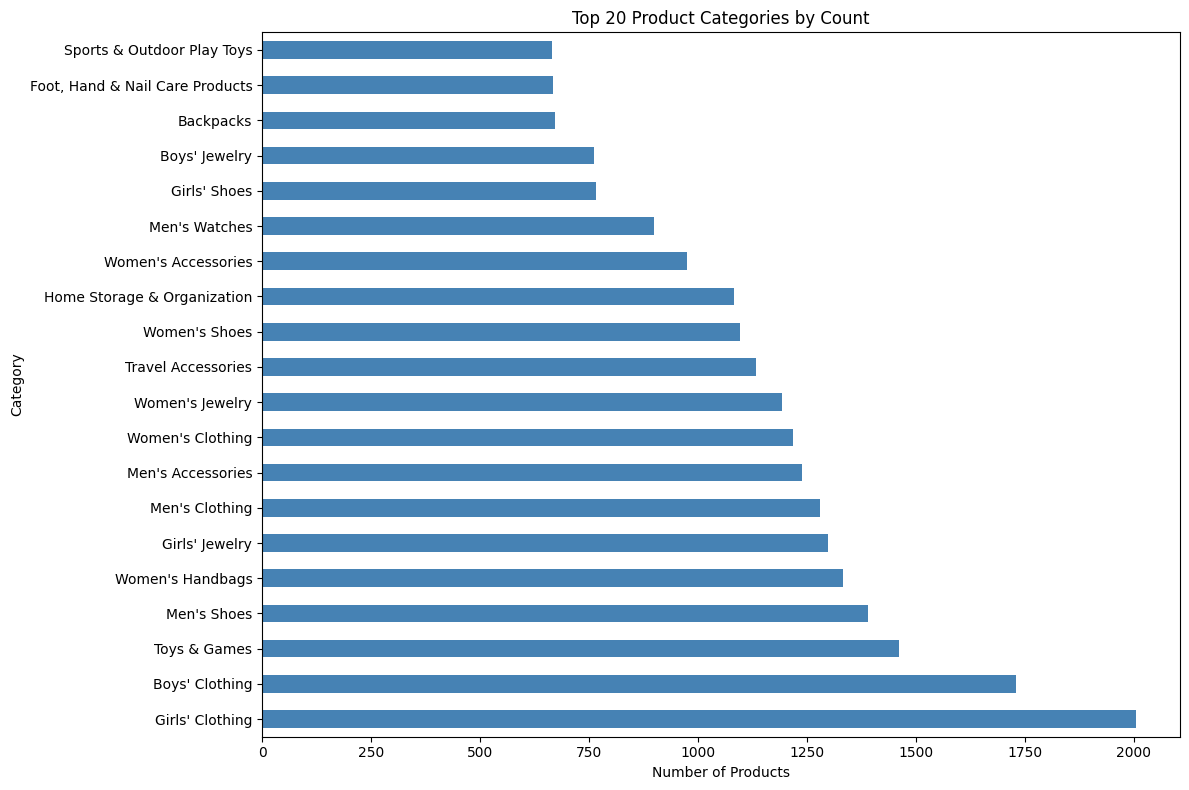


Total unique categories: 248


In [4]:
# Category distribution
category_counts = df['category_name'].value_counts().head(20)

plt.figure(figsize=(12, 8))
category_counts.plot(kind='barh', color='steelblue')
plt.title('Top 20 Product Categories by Count')
plt.xlabel('Number of Products')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

print(f"\nTotal unique categories: {df['category_name'].nunique()}")

## Star Rating Distribution

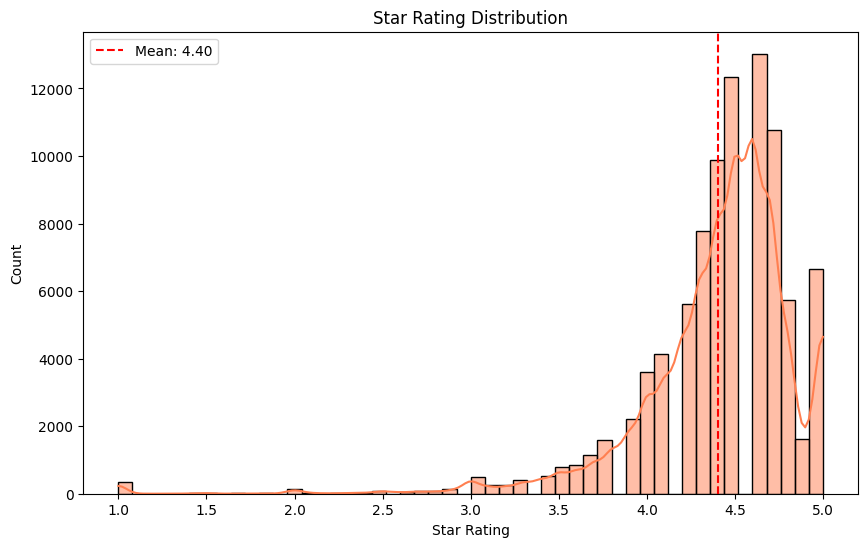

Average rating: 4.40
Median rating: 4.50


In [5]:
# Filter products with valid ratings
rated_products = df[df['stars'] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(rated_products['stars'], bins=50, kde=True, color='coral')
plt.title('Star Rating Distribution')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.axvline(rated_products['stars'].mean(), color='red', linestyle='--', label=f"Mean: {rated_products['stars'].mean():.2f}")
plt.legend()
plt.show()

print(f"Average rating: {rated_products['stars'].mean():.2f}")
print(f"Median rating: {rated_products['stars'].median():.2f}")

## Price Distribution by Category

<Figure size 1400x800 with 0 Axes>

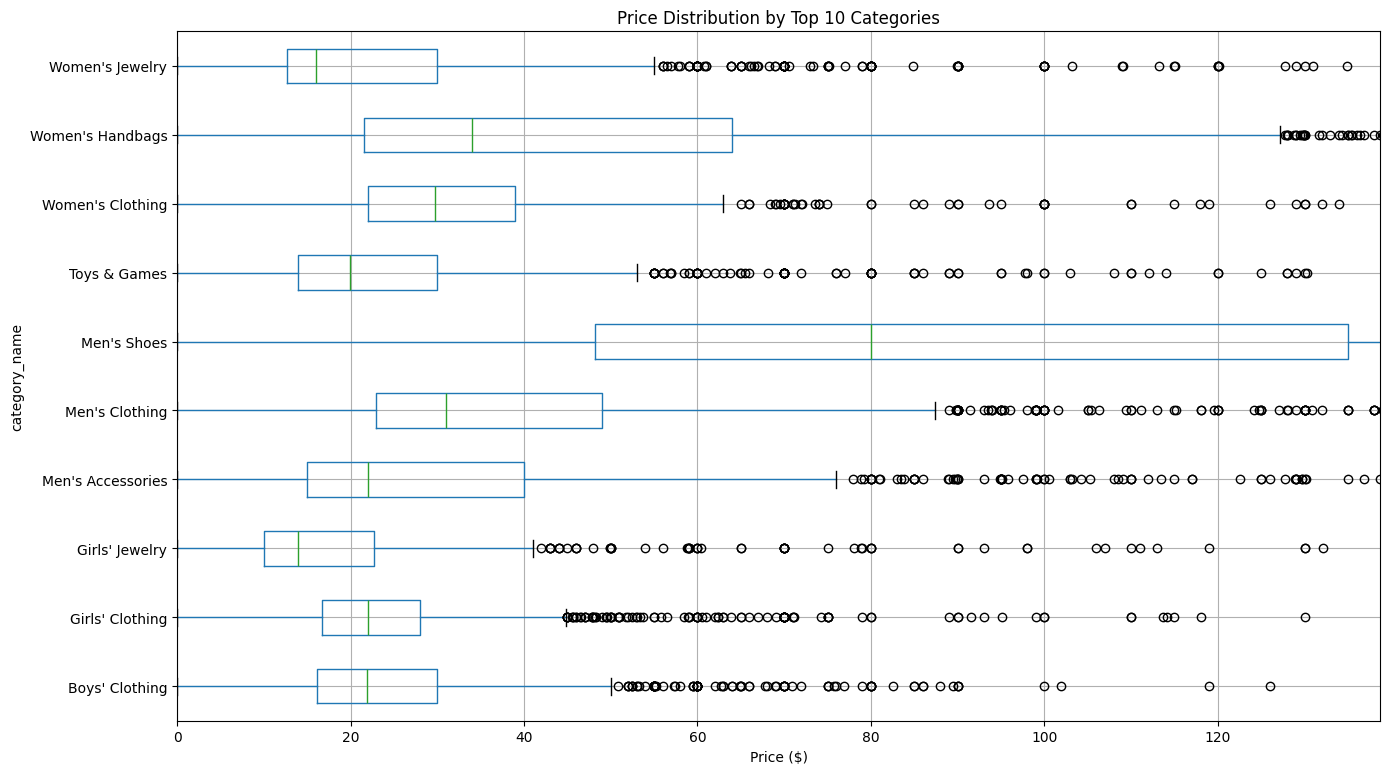

In [6]:
# Price distribution for top categories
top_categories = df['category_name'].value_counts().head(10).index.tolist()
df_top = df[df['category_name'].isin(top_categories)]

plt.figure(figsize=(14, 8))
df_top.boxplot(column='price', by='category_name', vert=False, figsize=(14, 8))
plt.title('Price Distribution by Top 10 Categories')
plt.suptitle('')
plt.xlabel('Price ($)')
plt.xlim(0, df_top['price'].quantile(0.95))  # Limit to 95th percentile
plt.tight_layout()
plt.show()

## Best Sellers Analysis

Total Best Sellers: 548


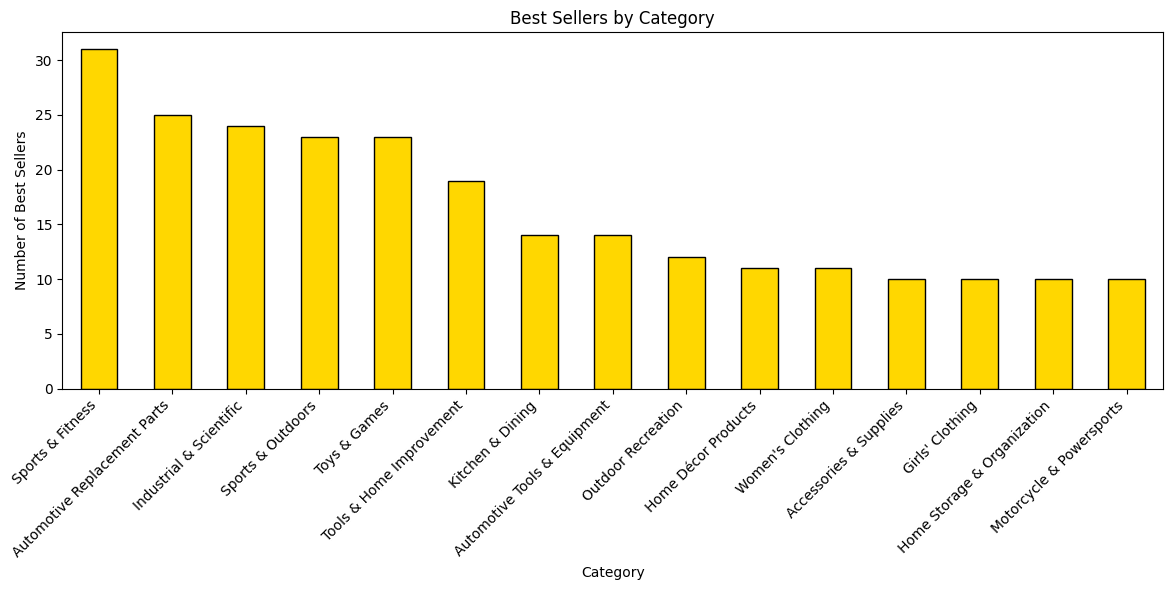

In [7]:
# Best sellers by category
best_sellers = df[df['isBestSeller'] == True]
print(f"Total Best Sellers: {len(best_sellers)}")

best_seller_by_category = best_sellers.groupby('category_name').size().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
best_seller_by_category.plot(kind='bar', color='gold', edgecolor='black')
plt.title('Best Sellers by Category')
plt.xlabel('Category')
plt.ylabel('Number of Best Sellers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Top Products by Sales Volume

In [8]:
# Top products by boughtInLastMonth
top_selling = df.nlargest(20, 'boughtInLastMonth')[['title', 'category_name', 'price', 'stars', 'boughtInLastMonth']]

print("Top 20 Products by Monthly Sales:")
display(top_selling)

Top 20 Products by Monthly Sales:


,title,category_name,price,stars,boughtInLastMonth
75619,"Nespresso Capsules VertuoLine, Melozio, Medium Roast Coffee, Coffee Pods, Brews 7.77 Fl Ounce (V...",Kitchen & Dining,37.50,4.8,80000
47017,"Mighty Patch Original - Hydrocolloid Acne Pimple Patch for Covering Zits and Blemishes, Spot Sti...",Personal Care Products,21.99,4.8,60000
72399,"BULKSUPPLEMENTS.COM Creatine Monohydrate Powder - Creatine Pre Workout, Creatine for Building Mu...",Sports Nutrition Products,21.96,4.6,50000
4505,"Sparkle® Pick-A-Size® Paper Towels, 24 Double Rolls = 48 Regular Rolls",Household Cleaning Supplies,26.36,4.7,40000
35940,"Everydrop by Whirlpool Ice and Water Refrigerator Filter 4, EDR4RXD1, Single-Pack",Tools & Home Improvement,48.29,4.7,40000
15572,"CeraVe SA Cleanser | Salicylic Acid Cleanser with Hyaluronic Acid, Niacinamide & Ceramides| BHA ...",Personal Care Products,12.37,4.7,30000
21961,"LEVOIT Air Purifier for Home Allergies Pets Hair in Bedroom, Covers Up to 1095 Sq.Foot Powered b...","Heating, Cooling & Air Quality",99.99,4.7,30000
38787,"Finish Dual Action Dishwasher Cleaner: Fight Grease & Limescale, Fresh, 8.45oz",Household Cleaning Supplies,4.88,4.6,30000
66974,Crest 3D White Professional Effects Teeth Whitening Kit,Oral Care Products,45.99,4.6,30000
73682,"Lysol Disinfectant Wipes, Multi-Surface Antibacterial Cleaning Wipes, For Disinfecting and Clean...",Household Cleaning Supplies,18.41,4.8,30000


## Price vs Rating Analysis

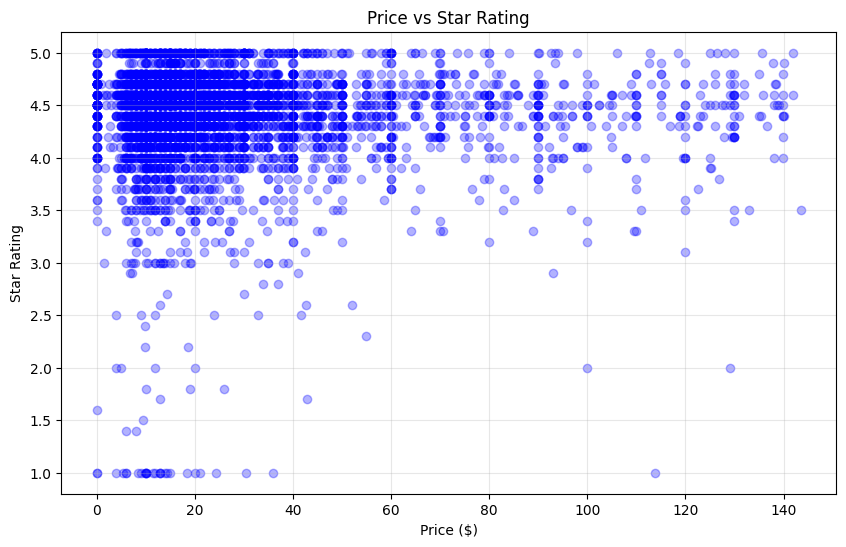


Correlation between Price and Rating: -0.0382


In [15]:
# Price vs Rating scatter plot
sample_df = df[(df['stars'] > 0) & (df['price'] < df['price'].quantile(0.95))].sample(min(5000, len(df)))

plt.figure(figsize=(10, 6))
plt.scatter(sample_df['price'], sample_df['stars'], alpha=0.3, c='blue', marker='o')
plt.title('Price vs Star Rating')
plt.xlabel('Price ($)')
plt.ylabel('Star Rating')
plt.grid(True, alpha=0.3)
plt.show()

# Correlation
correlation = df[df['stars'] > 0][['price', 'stars']].corr()
print(f"\nCorrelation between Price and Rating: {correlation.loc['price', 'stars']:.4f}")

# Feature Engineering
**Explanation:**  
This section creates new features that will be useful for bundle recommendations:
- Price buckets for segmentation
- Popularity scores based on reviews and sales
- Text features from product titles
- Category-level statistics

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Price Buckets
df['price_bucket'] = pd.cut(
    df['price'],
    bins=[0, 10, 25, 50, 100, 250, np.inf],
    labels=['<$10', '$10-25', '$25-50', '$50-100', '$100-250', '>$250']
)

# Popularity Score (normalized combination of reviews and monthly sales)
scaler = MinMaxScaler()
df['reviews_norm'] = scaler.fit_transform(df[['reviews']])
df['sales_norm'] = scaler.fit_transform(df[['boughtInLastMonth']])
df['popularity_score'] = 0.5 * df['reviews_norm'] + 0.5 * df['sales_norm']

# Rating Quality Score (weighted by number of reviews)
df['rating_quality'] = df['stars'] * np.log1p(df['reviews'])

# Value Score (rating relative to price)
df['value_score'] = df['stars'] / np.log1p(df['price'] + 1)

# Category average price and rating
category_stats = df.groupby('category_name').agg({
    'price': 'mean',
    'stars': 'mean',
    'boughtInLastMonth': 'sum'
}).rename(columns={
    'price': 'category_avg_price',
    'stars': 'category_avg_rating',
    'boughtInLastMonth': 'category_total_sales'
})

df = df.merge(category_stats, on='category_name', how='left')

# Price relative to category average
df['price_vs_category'] = df['price'] / df['category_avg_price']

print("Engineered Features:")
print(df[['title', 'price_bucket', 'popularity_score', 'rating_quality', 'value_score']].head(10))

Engineered Features:
                                                                                                 title  \
0                                            Christian Religious Rubber Bracelet with Card, 2 1/4 Inch   
1  2 Pcs Mickey Ears, Minnie Costume Ears Headband for Children Mom Baby Boys Girls Women Party (RE...   
2                                                    35 Light 13.5' Green Wire Red Chili Pepper String   
3  DeYeShiKi Motorcycle Mirrors ATV Mirrors, 360 Degrees Ball-Type Adjustment, 7/8" Handlebar with ...   
4  Cash Only Sign - 8 x 12 Aluminum - No Credit Card Sign - We Accept Only Cash Sign - Cash Only Si...   
5  Wedding Welcome Bags - 24 Piece Elegant Wedding Gift Bags with Word ‘’Welcome’’ Embossed in Gold...   
6        Fend-all 70 Ounce Bottle Sperian Saline Concentrate For Porta Stream I Eye Wash Station 1/BTL   
7                                        COVERGIRL Clean Fresh Skincare Weightless Water Cream, 2.0 Oz   
8  Twinkle 370pcs 9.8ft (

# Summary Statistics

In [17]:
print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"Total Products: {len(df):,}")
print(f"Unique Categories: {df['category_name'].nunique()}")
print(f"Best Sellers: {df['isBestSeller'].sum():,}")
print(f"\nPrice Statistics:")
print(f"  Mean: ${df['price'].mean():.2f}")
print(f"  Median: ${df['price'].median():.2f}")
print(f"  Range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
print(f"\nRating Statistics (rated products only):")
rated = df[df['stars'] > 0]
print(f"  Mean: {rated['stars'].mean():.2f}")
print(f"  Products with 4+ stars: {(rated['stars'] >= 4).sum():,} ({(rated['stars'] >= 4).mean()*100:.1f}%)")
print(f"\nSales Statistics:")
print(f"  Total Monthly Sales: {df['boughtInLastMonth'].sum():,}")
print(f"  Products with Sales: {(df['boughtInLastMonth'] > 0).sum():,}")

DATASET SUMMARY
Total Products: 100,000
Unique Categories: 248
Best Sellers: 548

Price Statistics:
  Mean: $43.52
  Median: $19.95
  Range: $0.00 - $12629.66

Rating Statistics (rated products only):
  Mean: 4.40
  Products with 4+ stars: 81,126 (89.4%)

Sales Statistics:
  Total Monthly Sales: 14,006,150
  Products with Sales: 35,700


# Common Words in Product Titles (WordCloud)

Top 30 Words in Product Titles:


,Word,Frequency
1,kids,8649
2,black,8550
3,girls,7790
4,women,7138
5,baby,6931
6,bag,6543
7,party,5316
8,boys,5080
9,kit,5077
10,white,4714


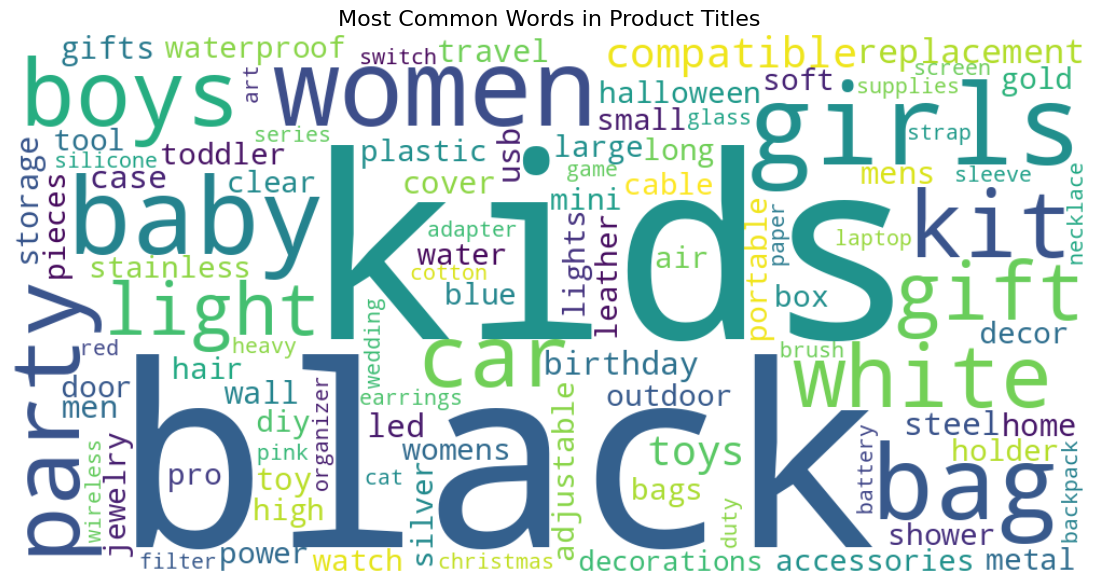

In [18]:
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
# Add domain-specific stopwords
custom_stops = {'pack', 'set', 'pcs', 'piece', 'inch', 'size', 'color', 'new', 'use', 'best', 'free'}
stop_words.update(custom_stops)

def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = text.split()
    return [word for word in tokens if word not in stop_words and len(word) > 2]

# Collect all words from titles
all_words = []
for title in df['title'].dropna():
    all_words.extend(tokenize(title))

word_counts = Counter(all_words)
most_common = word_counts.most_common(30)

print("Top 30 Words in Product Titles:")
word_df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])
word_df.index = word_df.index + 1
display(word_df)

# Generate WordCloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate_from_frequencies(dict(word_counts))

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Product Titles', fontsize=16)
plt.show()

# Setup (Part 2) - Machine Learning Libraries

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim.downloader as api

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Load Word2Vec model
print("Loading Word2Vec model (this may take a few minutes)...")
w2v_model = api.load("word2vec-google-news-300")
print("Word2Vec model loaded successfully!")

Loading Word2Vec model (this may take a few minutes)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec model loaded successfully!


# Clustering for Product Grouping
**Explanation:**  
We use K-Means clustering to group similar products together based on:
- TF-IDF features from product titles
- Numerical features (price, rating, popularity)

These clusters will help identify natural product groupings for bundle recommendations.

In [20]:
def preprocess_text(text):
    """Preprocess text for TF-IDF vectorization"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', "", text)
    text = re.sub(r'\d+', "", text)
    tokens = text.split()
    cleaned_tokens = []
    for word in tokens:
        if word not in stop_words and len(word) > 2:
            lemma = lemmatizer.lemmatize(word)
            cleaned_tokens.append(lemma)
    return ' '.join(cleaned_tokens)

# Sample data for clustering (for efficiency)
sample_size = min(10000, len(df))
df_sample = df.sample(n=sample_size, random_state=42).copy()

# Preprocess titles
df_sample['processed_title'] = df_sample['title'].apply(preprocess_text)
df_sample = df_sample[df_sample['processed_title'].str.strip().astype(bool)]

print(f"Clustering on {len(df_sample)} products...")

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf.fit_transform(df_sample['processed_title'])
tfidf_array = tfidf_matrix.toarray()

# Normalize numerical features
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(df_sample[['price', 'stars', 'popularity_score']].fillna(0))

# Combine features
combined_features = np.hstack([tfidf_array, numeric_features])

# Find optimal k using silhouette score
silhouette_scores = []
k_range = range(3, 12)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(combined_features)
    score = silhouette_score(combined_features, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

best_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {best_k}")

Clustering on 9998 products...
k=3: Silhouette Score = 0.0267
k=4: Silhouette Score = 0.0291
k=5: Silhouette Score = 0.0294
k=6: Silhouette Score = 0.0315
k=7: Silhouette Score = 0.0334
k=8: Silhouette Score = 0.0336
k=9: Silhouette Score = 0.0352
k=10: Silhouette Score = 0.0375
k=11: Silhouette Score = 0.0377

Optimal number of clusters: 11


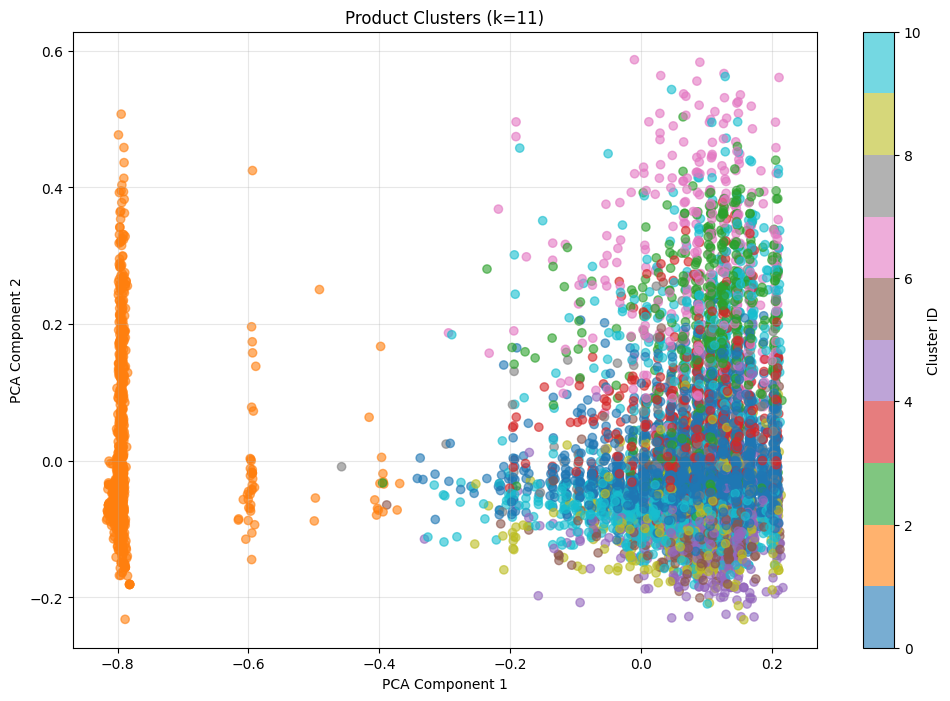


Cluster Summary:


,price,stars,popularity_score,product_count
cluster,,,,
0,35.93,4.45,0.0,3993
1,78.11,0.07,0.0,1031
2,34.03,4.46,0.0,666
3,27.72,4.43,0.0,571
4,25.52,4.49,0.0,645
5,37.20,4.37,0.0,334
6,27.71,4.42,0.0,363
7,29.92,4.49,0.0,365
8,62.52,4.33,0.0,494



Top Categories per Cluster:
Cluster 0: Home Storage & Organization, Wall Art, Automotive Tires & Wheels
Cluster 1: Boys' Clothing, Girls' Clothing, Virtual Reality Hardware & Accessories
Cluster 2: Girls' Clothing, Boys' Clothing, Women's Clothing
Cluster 3: Women's Jewelry, Girls' Jewelry, Puzzles
Cluster 4: Home Appliances, Heating, Cooling & Air Quality, Office Electronics
Cluster 5: Lights, Bulbs & Indicators, Light Bulbs, Lighting & Ceiling Fans
Cluster 6: Toys & Games, Baby & Toddler Toys, Sports & Outdoor Play Toys
Cluster 7: Women's Handbags, Travel Accessories, Gift Wrapping Supplies
Cluster 8: Men's Shoes, Men's Clothing, Men's Accessories
Cluster 9: Portable Audio & Video, Computers & Tablets, Tablet Accessories
Cluster 10: Baby Boys' Clothing & Shoes, Baby Care Products, Baby


In [21]:
# Final clustering with optimal k
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_sample['cluster'] = kmeans_final.fit_predict(combined_features)

# PCA for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(combined_features)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df_sample['cluster'], cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Cluster ID')
plt.title(f'Product Clusters (k={best_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True, alpha=0.3)
plt.show()

# Cluster summary
print("\nCluster Summary:")
cluster_summary = df_sample.groupby('cluster').agg({
    'price': 'mean',
    'stars': 'mean',
    'popularity_score': 'mean',
    'asin': 'count'
}).rename(columns={'asin': 'product_count'}).round(2)
display(cluster_summary)

# Top categories per cluster
print("\nTop Categories per Cluster:")
for cluster_id in sorted(df_sample['cluster'].unique()):
    top_cats = df_sample[df_sample['cluster'] == cluster_id]['category_name'].value_counts().head(3)
    print(f"Cluster {cluster_id}: {', '.join(top_cats.index.tolist())}")

# Content-Based Product Recommendations with Word2Vec
**Explanation:**  
We implement a content-based recommendation system using Word2Vec embeddings:
- Product titles are tokenized and converted to vector representations
- Cosine similarity is used to find similar products
- This forms the foundation for cross-selling recommendations

In [22]:
def tokenize_text(text):
    """Tokenize and clean text for Word2Vec"""
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', "", text)
    tokens = text.split()
    return [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 2
    ]

def get_product_vector(tokens, model):
    """Convert tokens to averaged Word2Vec vector"""
    valid_tokens = [t for t in tokens if t in model]
    if len(valid_tokens) < 2:
        return np.zeros(model.vector_size)
    return np.mean([model[t] for t in valid_tokens], axis=0)

# Prepare product data for recommendations
rec_df = df[['asin', 'title', 'category_name', 'price', 'stars', 'popularity_score']].copy()
rec_df = rec_df.drop_duplicates(subset='asin').reset_index(drop=True)
rec_df['tokens'] = rec_df['title'].apply(tokenize_text)
rec_df = rec_df[rec_df['tokens'].apply(len) >= 3]  # Keep products with enough tokens

print(f"Preparing vectors for {len(rec_df)} products...")

# Create product vectors
product_vectors = np.array([get_product_vector(tokens, w2v_model) for tokens in rec_df['tokens']])

# Normalize price and add to feature vector
scaler = MinMaxScaler()
price_norm = scaler.fit_transform(rec_df[['price']].fillna(0))

# Combined feature vector (Word2Vec + normalized price)
combined_vectors = np.hstack([product_vectors, price_norm])

print(f"Product vector shape: {combined_vectors.shape}")

Preparing vectors for 99326 products...
Product vector shape: (99326, 301)


In [24]:
rec_df.head(30)

,asin,title,category_name,price,stars,popularity_score,tokens
0,B07BM9CTPF,"Christian Religious Rubber Bracelet with Card, 2 1/4 Inch",Boys' Jewelry,14.99,4.3,0.000000,"[christian, religious, rubber, bracelet, card, inch]"
1,B07M8GSBRY,"2 Pcs Mickey Ears, Minnie Costume Ears Headband for Children Mom Baby Boys Girls Women Party (RE...",Women's Accessories,8.79,4.5,0.000625,"[pc, mickey, ear, minnie, costume, ear, headband, child, mom, baby, boy, girl, woman, party, red]"
2,B000TZQXXO,35 Light 13.5' Green Wire Red Chili Pepper String,Seasonal Décor,15.99,4.6,0.000000,"[light, 135, green, wire, red, chili, pepper, string]"
3,B07SHDN9PX,"DeYeShiKi Motorcycle Mirrors ATV Mirrors, 360 Degrees Ball-Type Adjustment, 7/8"" Handlebar with ...",Motorcycle & Powersports,14.85,4.4,0.000625,"[deyeshiki, motorcycle, mirror, atv, mirror, 360, degree, balltype, adjustment, handlebar, 8mm, ..."
4,B09HQQC8CT,Cash Only Sign - 8 x 12 Aluminum - No Credit Card Sign - We Accept Only Cash Sign - Cash Only Si...,Retail Store Fixtures & Equipment,8.49,4.1,0.000313,"[cash, sign, aluminum, credit, card, sign, accept, cash, sign, cash, sign, business, credit, sig..."
5,B07QSPN852,Wedding Welcome Bags - 24 Piece Elegant Wedding Gift Bags with Word ‘’Welcome’’ Embossed in Gold...,Gift Wrapping Supplies,19.99,4.7,0.000313,"[wedding, welcome, bag, piece, elegant, wedding, gift, bag, word, welcome, embossed, gold, foil,..."
6,B00AM42CFA,Fend-all 70 Ounce Bottle Sperian Saline Concentrate For Porta Stream I Eye Wash Station 1/BTL,Safety & Security,56.92,4.7,0.000625,"[fendall, ounce, bottle, sperian, saline, concentrate, porta, stream, eye, wash, station, 1btl]"
7,B09LB9PSC1,"COVERGIRL Clean Fresh Skincare Weightless Water Cream, 2.0 Oz",Skin Care Products,9.38,4.4,0.006250,"[covergirl, clean, fresh, skincare, weightless, water, cream]"
8,B07ZYTHPWH,"Twinkle 370pcs 9.8ft (0.03in+0.04in+0.06in) Starlight Headliner Fiber Optic Lights kit, Music Mo...",Home Lighting & Ceiling Fans,90.49,4.5,0.000313,"[twinkle, 370pcs, 98ft, 003in004in006in, starlight, headliner, fiber, optic, light, kit, music, ..."
9,B0C33KGT78,"Bright Outdoor Solar Pathway Lights 6 Pack,Color Changing/Warm White LED Solar Lights Outdoor Wa...",Lighting & Ceiling Fans,29.99,4.7,0.000000,"[bright, outdoor, solar, pathway, light, packcolor, changingwarm, white, led, solar, light, outd..."


In [25]:
import random

def recommend_similar_products(product_idx, n_recommendations=5):
    """Recommend similar products using cosine similarity"""
    # Calculate similarity with all products
    similarities = cosine_similarity([combined_vectors[product_idx]], combined_vectors)[0]
    
    # Get top similar products (excluding itself)
    similar_indices = similarities.argsort()[::-1][1:n_recommendations+1]
    
    return similar_indices, similarities[similar_indices]

# Demo: Recommend for a random product
random_idx = random.randint(0, len(rec_df) - 1)
selected_product = rec_df.iloc[10]

print(f"Selected Product:")
print(f"  Title: {selected_product['title'][:100]}...")
print(f"  Category: {selected_product['category_name']}")
print(f"  Price: ${selected_product['price']:.2f}")
print(f"  Rating: {selected_product['stars']}")

similar_idx, scores = recommend_similar_products(10)

print(f"\nTop 5 Similar Products (Cross-Sell Recommendations):")
print("-" * 80)
for i, (idx, score) in enumerate(zip(similar_idx, scores), 1):
    product = rec_df.iloc[idx]
    print(f"{i}. {product['title'][:70]}...")
    print(f"   Category: {product['category_name']} | Price: ${product['price']:.2f} | Similarity: {score:.3f}")

Selected Product:
  Title: 17.3 Inch Laptop Carry Bag with Handle for HP ENVY 17 17t/Pavilion 17/Omen 17, Acer Predator 17, Del...
  Category: Laptop Accessories
  Price: $17.95
  Rating: 4.6

Top 5 Similar Products (Cross-Sell Recommendations):
--------------------------------------------------------------------------------
1. LANDICI Laptop Bag Carrying Case 15.6 Inch with Shoulder Strap, Slim W...
   Category: Laptop Accessories | Price: $22.99 | Similarity: 0.932
2. MicaYoung Laptop Sleeve Shoulder Bag 13-14 Inch PC Portable Handbag Ca...
   Category: Laptop Bags | Price: $16.99 | Similarity: 0.914
3. 15.6’’ Laptop Case Sleeve, Electronic Organizer Waterproof with Outsid...
   Category: Laptop Accessories | Price: $28.99 | Similarity: 0.898
4. MOSISO Laptop Bag for Women, 15 inch Computer Bag Compatible with MacB...
   Category: Laptop Bags | Price: $25.99 | Similarity: 0.885
5. Laptop Sleeve Bag 15.6 Inch, Durable Slim Briefcase Handle Bag & with ...
   Category: Laptop Accessorie

# Association Rule Mining for Bundle Recommendations
**Explanation:**  
We use the Apriori algorithm to find frequently co-purchased items and generate association rules. This helps identify which products are commonly bought together, enabling bundle recommendations.

Since we don't have actual transaction data, we simulate transactions based on category co-occurrence and product similarity.

In [26]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Simulate transactions based on category groupings and price tiers
# Products in the same category and price range are likely to be browsed/bought together

def generate_synthetic_transactions(df, n_transactions=5000):
    """Generate synthetic transactions for association rule mining"""
    transactions = []
    
    # Group products by category
    category_products = df.groupby('category_name')['asin'].apply(list).to_dict()
    categories = list(category_products.keys())
    
    for _ in range(n_transactions):
        # Randomly select 2-4 categories
        n_categories = random.randint(1, 3)
        selected_cats = random.sample(categories, min(n_categories, len(categories)))
        
        basket = []
        for cat in selected_cats:
            products = category_products[cat]
            # Select 1-3 products from each category
            n_products = random.randint(1, min(3, len(products)))
            basket.extend(random.sample(products, n_products))
        
        if len(basket) >= 2:
            transactions.append(basket)
    
    return transactions

# Generate transactions
print("Generating synthetic transactions...")
transactions = generate_synthetic_transactions(df, n_transactions=10000)
print(f"Generated {len(transactions)} transactions")
print(f"Average basket size: {np.mean([len(t) for t in transactions]):.2f} items")

Generating synthetic transactions...
Generated 8880 transactions
Average basket size: 4.36 items


In [46]:
# Convert transactions to one-hot encoded format
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_array, columns=te.columns_)

print(f"Transaction matrix shape: {transaction_df.shape}")

# Apply Apriori algorithm
print("\nRunning Apriori algorithm...")
frequent_itemsets = apriori(transaction_df, min_support=0.004, use_colnames=True)
print(f"Found {len(frequent_itemsets)} frequent itemsets")

# Generate association rules
if len(frequent_itemsets) > 0:
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    rules = rules.sort_values('lift', ascending=False)
    print(f"Generated {len(rules)} association rules")
    
    # Display top rules
    print("\nTop 10 Association Rules (by Lift):")
    display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
else:
    print("No frequent itemsets found. Try lowering min_support.")

Transaction matrix shape: (8880, 27448)

Running Apriori algorithm...
Found 15 frequent itemsets
Generated 6 association rules

Top 10 Association Rules (by Lift):


,antecedents,consequents,support,confidence,lift
3,(B098R6JQ8S),(B08M99QL8T),0.004167,0.711538,114.881119
2,(B08M99QL8T),(B098R6JQ8S),0.004167,0.672727,114.881119
1,(B09TX12PXS),(B00KQS35XA),0.004054,0.679245,107.708895
0,(B00KQS35XA),(B09TX12PXS),0.004054,0.642857,107.708895
4,(B08M99QL8T),(B09C24TYGQ),0.004167,0.672727,99.563636
5,(B09C24TYGQ),(B08M99QL8T),0.004167,0.616667,99.563636


# Category-Based Bundle Recommendations
**Explanation:**  
We analyze which categories are frequently bought together and create bundle recommendations based on:
- Category co-occurrence patterns
- Complementary product relationships
- Price optimization for bundles

In [47]:
# Analyze category co-occurrence in transactions
def get_category_from_asin(asin, df):
    """Get category name for a product"""
    match = df[df['asin'] == asin]['category_name']
    return match.iloc[0] if len(match) > 0 else None

# Create category-level transactions
category_transactions = []
for transaction in transactions:
    cats = set()
    for asin in transaction:
        cat = get_category_from_asin(asin, df)
        if cat:
            cats.add(cat)
    if len(cats) >= 2:
        category_transactions.append(list(cats))

print(f"Category-level transactions: {len(category_transactions)}")

# Category co-occurrence matrix
from itertools import combinations

category_pairs = Counter()
for trans in category_transactions:
    for pair in combinations(sorted(trans), 2):
        category_pairs[pair] += 1

# Top category pairs
print("\nTop 15 Category Pairs (frequently bought together):")
top_pairs = category_pairs.most_common(15)
pairs_df = pd.DataFrame(top_pairs, columns=['Category Pair', 'Co-occurrence Count'])
pairs_df['Category 1'] = pairs_df['Category Pair'].apply(lambda x: x[0])
pairs_df['Category 2'] = pairs_df['Category Pair'].apply(lambda x: x[1])
display(pairs_df[['Category 1', 'Category 2', 'Co-occurrence Count']])

Category-level transactions: 6662

Top 15 Category Pairs (frequently bought together):


,Category 1,Category 2,Co-occurrence Count
0,Novelty Toys & Amusements,"Wii U Games, Consoles & Accessories",5
1,Finger Toys,Security & Surveillance Equipment,5
2,Automotive Enthusiast Merchandise,Measuring & Layout,5
3,Baby & Child Care Products,"PlayStation 5 Consoles, Games & Accessories",4
4,Sports & Outdoor Play Toys,Toy Vehicle Playsets,4
5,Industrial Materials,Online Video Game Services,4
6,Electronic Components,Men's Watches,4
7,Industrial Materials,"Sony PSP Games, Consoles & Accessories",4
8,Cat Supplies,Craft & Hobby Fabric,4
9,RV Parts & Accessories,Tools & Home Improvement,4


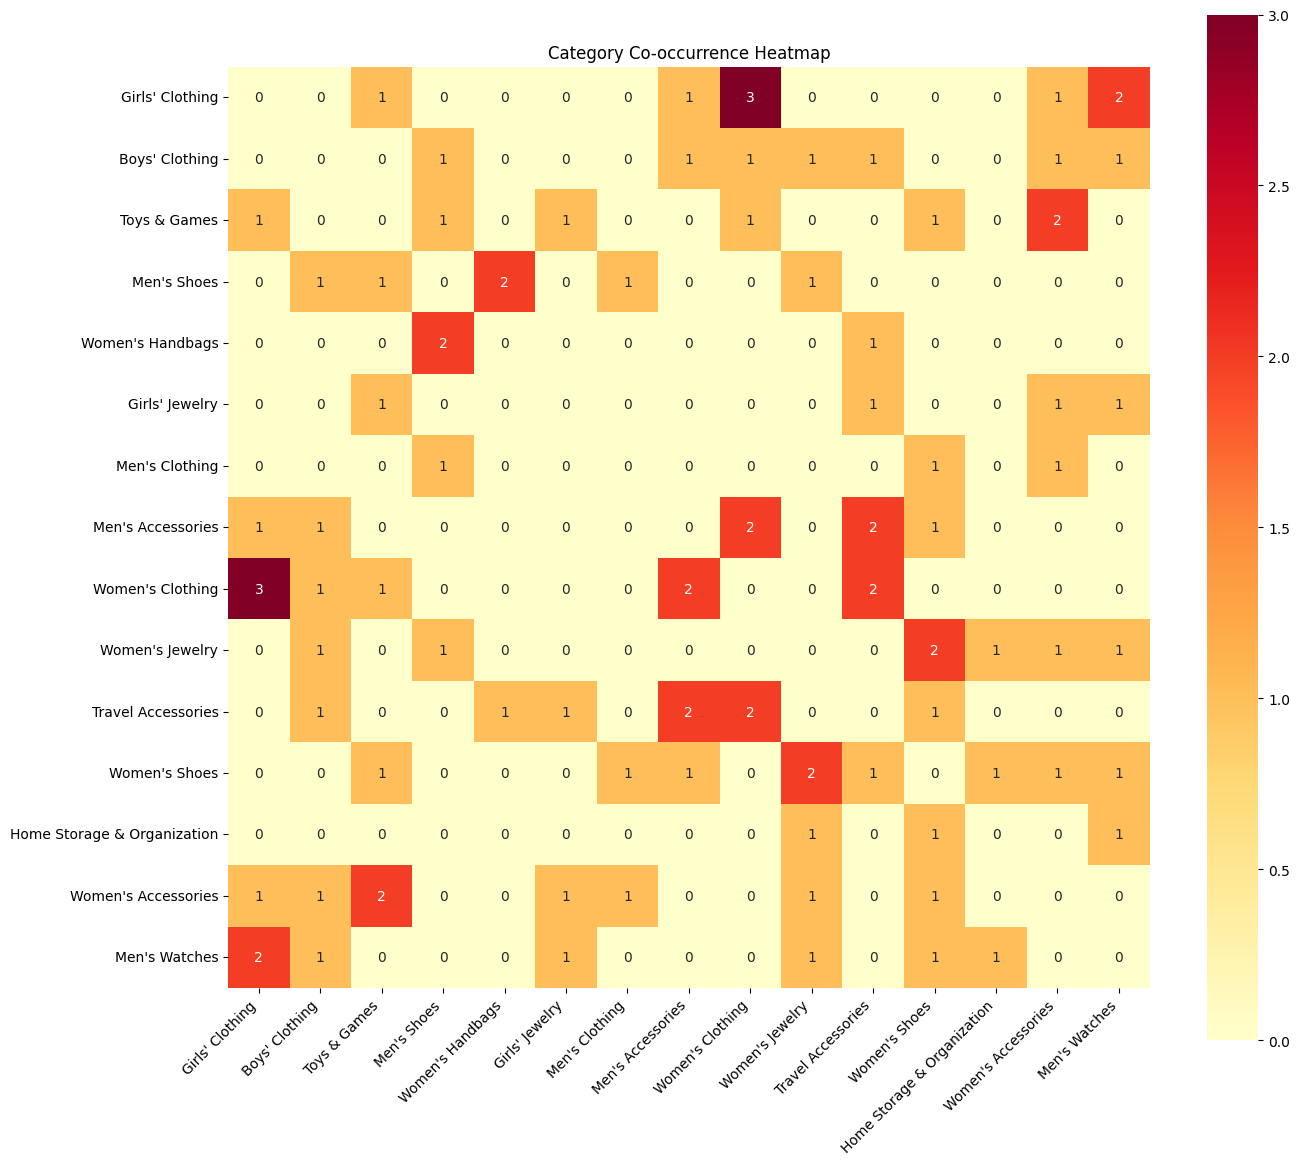

In [48]:
# Visualize category co-occurrence heatmap
top_categories = df['category_name'].value_counts().head(15).index.tolist()
cooc_matrix = pd.DataFrame(0, index=top_categories, columns=top_categories)

for (cat1, cat2), count in category_pairs.items():
    if cat1 in top_categories and cat2 in top_categories:
        cooc_matrix.loc[cat1, cat2] = count
        cooc_matrix.loc[cat2, cat1] = count

plt.figure(figsize=(14, 12))
sns.heatmap(cooc_matrix, annot=True, fmt='d', cmap='YlOrRd', square=True)
plt.title('Category Co-occurrence Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Bundle Generator
**Explanation:**  
This function creates optimized product bundles based on:
1. Product similarity (from Word2Vec embeddings)
2. Category diversity (different but complementary categories)
3. Price optimization (target bundle price)
4. Quality assurance (minimum rating threshold)

In [49]:
def generate_bundle(anchor_product_idx, bundle_size=3, max_price=None, min_rating=3.5):
    """
    Generate a product bundle based on an anchor product.
    
    Parameters:
    - anchor_product_idx: Index of the main product
    - bundle_size: Total number of products in bundle (including anchor)
    - max_price: Maximum total bundle price
    - min_rating: Minimum rating for bundle products
    """
    anchor = rec_df.iloc[anchor_product_idx]
    anchor_category = anchor['category_name']
    
    # Calculate similarities
    similarities = cosine_similarity([combined_vectors[anchor_product_idx]], combined_vectors)[0]
    
    # Create candidate products dataframe
    candidates = rec_df.copy()
    candidates['similarity'] = similarities
    
    # Filter candidates
    candidates = candidates[
        (candidates.index != anchor_product_idx) &  # Exclude anchor
        (candidates['stars'] >= min_rating) &  # Minimum rating
        (candidates['category_name'] != anchor_category)  # Different category for diversity
    ]
    
    # Sort by similarity and select top candidates
    candidates = candidates.sort_values('similarity', ascending=False)
    
    # Build bundle
    bundle = [anchor_product_idx]
    bundle_price = anchor['price']
    used_categories = {anchor_category}
    
    for idx, row in candidates.iterrows():
        if len(bundle) >= bundle_size:
            break
        
        # Check price constraint
        if max_price and (bundle_price + row['price']) > max_price:
            continue
        
        # Prefer category diversity
        if row['category_name'] in used_categories:
            continue
        
        bundle.append(idx)
        bundle_price += row['price']
        used_categories.add(row['category_name'])
    
    return bundle, bundle_price

# Demo: Generate bundles for random products
print("BUNDLE RECOMMENDATIONS")
print("=" * 80)

for _ in range(3):
    anchor_idx = random.randint(0, len(rec_df) - 1)
    bundle_indices, total_price = generate_bundle(anchor_idx, bundle_size=4, max_price=200)
    
    print(f"\n📦 Bundle (Total: ${total_price:.2f}):")
    print("-" * 60)
    for i, idx in enumerate(bundle_indices):
        product = rec_df.iloc[idx]
        marker = "⭐ ANCHOR" if i == 0 else f"  Item {i}"
        print(f"{marker}: {product['title'][:100]}...")
        print(f"         Category: {product['category_name']} | ${product['price']:.2f} | ⭐{product['stars']}")

BUNDLE RECOMMENDATIONS

📦 Bundle (Total: $149.90):
------------------------------------------------------------
⭐ ANCHOR: [UL Listed] Power Cord Cable Compatible with Brother Singer Janome Viking White Pfaff Baby-Lock Bern...
         Category: Sewing Products | $9.98 | ⭐4.7
  Item 1: FlashFix Refill Kit | UV Cured Liquid Plastic Super Adhesive Refill Kit...
         Category: Industrial Adhesives, Sealants & Lubricants | $17.95 | ⭐3.9
  Item 2: Bralette for Women Removable Padded Bra Yoga Seamless V Neck Triangle Adjustable Straps Wireless...
         Category: Women's Clothing | $33.99 | ⭐4.0
  Item 3: Saf-T-Ear SafetyBuds Electronic Hearing Protection, Yellow (ERSTEBUDS)...
         Category: Headphones & Earbuds | $59.95 | ⭐3.5

📦 Bundle (Total: $199.98):
------------------------------------------------------------
⭐ ANCHOR: Unisex-Adult Exposure/2 Gore-tex Glove...
         Category: Men's Accessories | $170.00 | ⭐4.6
  Item 1: Elements Winter Fabric Weighted Door Stoppers Snowmen

In [38]:
rec_df.head()

,asin,title,category_name,price,stars,popularity_score,tokens
0,B07BM9CTPF,"Christian Religious Rubber Bracelet with Card, 2 1/4 Inch",Boys' Jewelry,14.99,4.3,0.000000,"[christian, religious, rubber, bracelet, card, inch]"
1,B07M8GSBRY,"2 Pcs Mickey Ears, Minnie Costume Ears Headband for Children Mom Baby Boys Girls Women Party (RE...",Women's Accessories,8.79,4.5,0.000625,"[pc, mickey, ear, minnie, costume, ear, headband, child, mom, baby, boy, girl, woman, party, red]"
2,B000TZQXXO,35 Light 13.5' Green Wire Red Chili Pepper String,Seasonal Décor,15.99,4.6,0.000000,"[light, 135, green, wire, red, chili, pepper, string]"
3,B07SHDN9PX,"DeYeShiKi Motorcycle Mirrors ATV Mirrors, 360 Degrees Ball-Type Adjustment, 7/8"" Handlebar with ...",Motorcycle & Powersports,14.85,4.4,0.000625,"[deyeshiki, motorcycle, mirror, atv, mirror, 360, degree, balltype, adjustment, handlebar, 8mm, ..."
4,B09HQQC8CT,Cash Only Sign - 8 x 12 Aluminum - No Credit Card Sign - We Accept Only Cash Sign - Cash Only Si...,Retail Store Fixtures & Equipment,8.49,4.1,0.000313,"[cash, sign, aluminum, credit, card, sign, accept, cash, sign, cash, sign, business, credit, sig..."


In [50]:
bundle_indices, total_price = generate_bundle(0, bundle_size=5, max_price=100)
    
print(f"\n📦 Bundle (Total: ${total_price:.2f}):")
print("-" * 60)
for i, idx in enumerate(bundle_indices):
    product = rec_df.iloc[idx]
    marker = "⭐ ANCHOR" if i == 0 else f"  Item {i}"
    print(f"{marker}: {product['title'][:100]}...")
    print(f"         Category: {product['category_name']} | ${product['price']:.2f} | ⭐{product['stars']}")


📦 Bundle (Total: $59.95):
------------------------------------------------------------
⭐ ANCHOR: Christian Religious Rubber Bracelet with Card, 2 1/4 Inch...
         Category: Boys' Jewelry | $14.99 | ⭐4.3
  Item 1: TENS Unit Muscle Stimulator with 24 Modes Rechargeable TENS EMS Device Electronic Pulse Massager Phy...
         Category: Home Use Medical Supplies & Equipment | $31.98 | ⭐4.4
  Item 2: SS20 AB Crystal Diamond Rhinestones Flat Back Round Rhinestones Iridescent Crystals Round Beads Flat...
         Category: Sewing Products | $7.99 | ⭐4.8
  Item 3: 2.5G USB-C And USB To Ethernet Adapter...
         Category: Televisions & Video Products | $28.95 | ⭐4.3
  Item 4: Micro Blocks Pen Holder, Building Toy, Office or Home Decoration...
         Category: Building Toys | $29.99 | ⭐0.0


# Cross-Selling Recommendation Engine
**Explanation:**  
A comprehensive cross-selling system that combines:
1. Content-based similarity (Word2Vec)
2. Category affinity scores
3. Price compatibility
4. Popularity weighting

In [51]:
class CrossSellRecommender:
    def __init__(self, products_df, product_vectors):
        self.df = products_df
        self.vectors = product_vectors
        self.category_affinity = self._compute_category_affinity()
    
    def _compute_category_affinity(self):
        """Compute category affinity matrix from co-occurrence"""
        categories = self.df['category_name'].unique()
        affinity = pd.DataFrame(0.0, index=categories, columns=categories)
        
        # Use category pair frequencies
        for (cat1, cat2), count in category_pairs.items():
            if cat1 in categories and cat2 in categories:
                affinity.loc[cat1, cat2] = count
                affinity.loc[cat2, cat1] = count
        
        # Normalize
        affinity = affinity / (affinity.max().max() + 1e-9)
        return affinity
    
    def recommend(self, product_idx, n_recommendations=5, 
                  content_weight=0.5, category_weight=0.3, popularity_weight=0.2):
        """
        Generate cross-sell recommendations.
        
        Parameters:
        - product_idx: Index of the source product
        - n_recommendations: Number of recommendations
        - content_weight: Weight for content similarity
        - category_weight: Weight for category affinity
        - popularity_weight: Weight for popularity
        """
        source = self.df.iloc[product_idx]
        source_category = source['category_name']
        
        # Content similarity
        content_sim = cosine_similarity([self.vectors[product_idx]], self.vectors)[0]
        
        # Category affinity
        category_scores = np.array([
            self.category_affinity.loc[source_category, cat] 
            if cat in self.category_affinity.index and source_category in self.category_affinity.index
            else 0
            for cat in self.df['category_name']
        ])
        
        # Popularity scores
        popularity = self.df['popularity_score'].fillna(0).values
        
        # Combine scores
        final_scores = (
            content_weight * content_sim +
            category_weight * category_scores +
            popularity_weight * popularity
        )
        
        # Exclude same product and same category
        final_scores[product_idx] = -1
        same_category_mask = self.df['category_name'] == source_category
        final_scores[same_category_mask] = final_scores[same_category_mask] * 0.5  # Penalize same category
        
        # Get top recommendations
        top_indices = final_scores.argsort()[::-1][:n_recommendations]
        
        return top_indices, final_scores[top_indices]

# Initialize recommender
recommender = CrossSellRecommender(rec_df, combined_vectors)

# Demo recommendations
print("CROSS-SELL RECOMMENDATIONS")
print("=" * 80)

for _ in range(3):
    idx = random.randint(0, len(rec_df) - 1)
    product = rec_df.iloc[idx]
    
    print(f"\n🛒 Customer viewing: {product['title'][:60]}...")
    print(f"   Category: {product['category_name']} | Price: ${product['price']:.2f}")
    print(f"\n   Customers also bought:")
    
    recs, scores = recommender.recommend(idx, n_recommendations=5)
    for i, (rec_idx, score) in enumerate(zip(recs, scores), 1):
        rec_product = rec_df.iloc[rec_idx]
        print(f"   {i}. {rec_product['title'][:50]}...")
        print(f"      {rec_product['category_name']} | ${rec_product['price']:.2f} | Score: {score:.3f}")

CROSS-SELL RECOMMENDATIONS

🛒 Customer viewing: Isonzo: Deluxe Edition (PS4)...
   Category: PlayStation 4 Games, Consoles & Accessories | Price: $26.84

   Customers also bought:
   1. Isonzo: Deluxe Edition (PS5)...
      PlayStation 5 Consoles, Games & Accessories | $20.38 | Score: 0.500
   2. The Sims Deluxe Edition - PC...
      PC Games & Accessories | $32.88 | Score: 0.490
   3. Afterimage [Deluxe Edition]...
      PlayStation 5 Consoles, Games & Accessories | $37.88 | Score: 0.462
   4. Bezier Games Cabo Deluxe Edition...
      Games & Accessories | $24.61 | Score: 0.421
   5. Devil May Cry 5 Deluxe Edition - Xbox One Deluxe E...
      Xbox One Games, Consoles & Accessories | $0.00 | Score: 0.417

🛒 Customer viewing: KidKraft Wooden Step 'N Store Stool with Handles and Hidden ...
   Category: Kids' Furniture | Price: $33.04

   Customers also bought:
   1. Toy Organizer.72 Compartments.Toy Storage Box Comp...
      Kids' Play Cars & Race Cars | $45.99 | Score: 0.584
   2. Hot W

# Bundle Evaluation Metrics
**Explanation:**  
We evaluate the quality of our bundles using several metrics:
- Diversity: How varied are the categories in the bundle?
- Coherence: How similar are the products thematically?
- Value: Average rating and popularity of bundled products
- Price efficiency: Bundle price vs sum of individual prices

In [55]:
def evaluate_bundle(bundle_indices):
    """
    Evaluate the quality of a product bundle.
    """
    bundle_products = rec_df.loc[bundle_indices]
    
    # Diversity: Number of unique categories / bundle size
    n_categories = bundle_products['category_name'].nunique()
    diversity = n_categories / len(bundle_indices)
    
    # Coherence: Average pairwise similarity
    # Convert label indices to positional indices for numpy array access
    positional_indices = [rec_df.index.get_loc(idx) for idx in bundle_indices]
    bundle_vectors = combined_vectors[positional_indices]
    pairwise_sim = cosine_similarity(bundle_vectors)
    # Get upper triangle (excluding diagonal)
    upper_triangle = pairwise_sim[np.triu_indices(len(bundle_indices), k=1)]
    coherence = upper_triangle.mean() if len(upper_triangle) > 0 else 0
    
    # Value metrics
    avg_rating = bundle_products['stars'].mean()
    avg_popularity = bundle_products['popularity_score'].mean()
    
    # Price
    total_price = bundle_products['price'].sum()
    
    return {
        'diversity': diversity,
        'coherence': coherence,
        'avg_rating': avg_rating,
        'avg_popularity': avg_popularity,
        'total_price': total_price,
        'n_products': len(bundle_indices)
    }

# Evaluate multiple bundles
print("BUNDLE QUALITY EVALUATION")
print("=" * 80)

evaluation_results = []
for i in range(10):
    anchor_idx = random.randint(0, len(rec_df) - 1)
    bundle_indices, _ = generate_bundle(anchor_idx, bundle_size=4)
    
    if len(bundle_indices) >= 2:
        metrics = evaluate_bundle(bundle_indices)
        evaluation_results.append(metrics)

eval_df = pd.DataFrame(evaluation_results)
print("\nBundle Quality Metrics (averaged over 10 bundles):")
print(f"  Average Diversity: {eval_df['diversity'].mean():.3f}")
print(f"  Average Coherence: {eval_df['coherence'].mean():.3f}")
print(f"  Average Rating: {eval_df['avg_rating'].mean():.2f}")
print(f"  Average Bundle Price: ${eval_df['total_price'].mean():.2f}")

print("\nDetailed Results:")
display(eval_df.round(3))

BUNDLE QUALITY EVALUATION

Bundle Quality Metrics (averaged over 10 bundles):
  Average Diversity: 1.000
  Average Coherence: 0.623
  Average Rating: 4.08
  Average Bundle Price: $128.21

Detailed Results:


,diversity,coherence,avg_rating,avg_popularity,total_price,n_products
0,1.0,0.687,4.525,0.001,143.76,4
1,1.0,0.588,4.225,0.000,56.96,4
2,1.0,0.565,4.250,0.003,272.90,4
3,1.0,0.490,4.700,0.001,132.87,4
4,1.0,0.783,4.575,0.000,132.57,4
5,1.0,0.609,4.375,0.002,106.83,4
6,1.0,0.580,4.400,0.000,101.47,4
7,1.0,0.643,3.325,0.001,166.10,4
8,1.0,0.605,3.300,0.001,107.25,4
9,1.0,0.678,3.150,0.003,61.36,4


# Summary and Conclusions

## Implemented Techniques:

1. **Data Preprocessing & Feature Engineering**
   - Cleaned and normalized product data
   - Created popularity scores, value scores, and price buckets
   - Generated text features from product titles

2. **Clustering (K-Means)**
   - Grouped similar products using TF-IDF and numerical features
   - Used silhouette scores to find optimal cluster count
   - Identified natural product groupings

3. **Content-Based Recommendations (Word2Vec)**
   - Vectorized product titles using Word2Vec embeddings
   - Calculated cosine similarity for product matching
   - Combined with price features for better recommendations

4. **Association Rule Mining (Apriori)**
   - Generated synthetic transactions for basket analysis
   - Discovered frequent itemsets and association rules
   - Identified category co-occurrence patterns

5. **Bundle Generator**
   - Created optimized product bundles based on:
     - Product similarity
     - Category diversity
     - Price constraints
     - Quality thresholds

6. **Cross-Selling Recommender**
   - Combined multiple signals:
     - Content similarity
     - Category affinity
     - Popularity weighting
   - Configurable weights for different business needs

## Key Findings:
- Product clustering reveals natural groupings based on title semantics and pricing
- Category co-occurrence analysis helps identify complementary product categories
- Hybrid approaches (combining content + category + popularity) yield better recommendations
- Bundle diversity can be balanced with coherence through careful parameter tuning

In [56]:
# Final summary statistics
print("=" * 60)
print("PROJECT SUMMARY")
print("=" * 60)
print(f"\nDataset:")
print(f"  Total Products: {len(df):,}")
print(f"  Categories: {df['category_name'].nunique()}")
print(f"  Price Range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
print(f"\nRecommendation System:")
print(f"  Products indexed: {len(rec_df):,}")
print(f"  Feature dimensions: {combined_vectors.shape[1]}")
print(f"\nClustering:")
print(f"  Optimal clusters: {best_k}")
print(f"  Best silhouette score: {max(silhouette_scores):.4f}")
print(f"\nAssociation Rules:")
if 'rules' in dir() and len(rules) > 0:
    print(f"  Total rules generated: {len(rules)}")
    print(f"  Max lift: {rules['lift'].max():.2f}")
print(f"\nBundle Quality (avg over 10 samples):")
print(f"  Diversity: {eval_df['diversity'].mean():.3f}")
print(f"  Coherence: {eval_df['coherence'].mean():.3f}")

PROJECT SUMMARY

Dataset:
  Total Products: 100,000
  Categories: 248
  Price Range: $0.00 - $12629.66

Recommendation System:
  Products indexed: 99,326
  Feature dimensions: 301

Clustering:
  Optimal clusters: 11
  Best silhouette score: 0.0377

Association Rules:
  Total rules generated: 6
  Max lift: 114.88

Bundle Quality (avg over 10 samples):
  Diversity: 1.000
  Coherence: 0.623
